In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import pandas as pd


In [15]:
max_distance = 1500  # 15km

def create_data_model(distances, coordinates):
    data = {}
    
    """데이터 모델을 생성합니다."""
    dist_matrix = distances.values.tolist()
    data['distance_matrix'] = dist_matrix

    coord_matrix = coordinates.values.tolist()
    data['locations'] = coord_matrix

    data['num_vehicles'] = 15
    data['depot'] = 0


    return data

def solve():
    """VRP 문제를 설정하고 해결합니다."""
    coord = pd.read_csv("selected_sites.txt", sep=',')
    dist =pd.read_csv("dist.csv", index_col=0)
    data = create_data_model(dist, coord)

    # 노드 수, 차량 수, 출발/도착 지점을 설정
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # 경로 모델 생성
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """두 노드 간의 거리를 계산하는 콜백 함수"""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    # 거리 콜백 함수 등록
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # 비용 함수 설정
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # 거리 차원 생성
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        max_distance,  # 각 차량의 최대 이동 거리
        True,  # start cumul to zero
        dimension_name)
    
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(0)

    # 탐색 매개변수 설정
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # 다양한 첫 번째 솔루션 전략 시도
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    # search_parameters.time_limit.seconds = 300
    search_parameters.solution_limit = 1000
    # 로그 출력을 비활성화
    search_parameters.log_search = True

    # 문제 해결
    solution = routing.SolveWithParameters(search_parameters)

    return manager, routing, solution, distance_dimension, data

def print_solution(manager, routing, solution, distance_dimension, data):
    """해결책을 출력하고 시각화합니다."""
    print('Objective: {}'.format(solution.ObjectiveValue()))
    total_distance = 0
    routes = []
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route = []
        route_distance = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            plan_output += ' {} ->'.format(node_index)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        plan_output += ' {}\n'.format(node_index)
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        print(plan_output)
        routes.append(route)
        total_distance += route_distance
    print('Total distance of all routes: {}km'.format(total_distance))

    return routes



def plot_routes(locations, routes):
    import matplotlib.pyplot as plt
    """경로를 시각화합니다."""
    plt.figure(figsize=(12, 8))
    colors = cm.rainbow(np.linspace(0, 1, len(routes)))
    for route, color in zip(routes, colors):
        x_coords = [locations[node][0] for node in route]
        y_coords = [locations[node][1] for node in route]
        for i in range(len(route) - 1):
            plt.quiver(x_coords[i], y_coords[i], x_coords[i + 1] - x_coords[i], y_coords[i + 1] - y_coords[i],
                        angles='xy', scale_units='xy', scale=1, color=color, width=0.003)
        for i, node in enumerate(route):
            plt.text(locations[node][0], locations[node][1], str(node), fontsize=12, ha='right')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Vehicle Routes')
    plt.grid()
    plt.show()

def plot_individual_routes(locations, routes):
    _routes = routes
        
    """경로를 시각화합니다."""
    num_routes = len(_routes)
    fig, axes = plt.subplots(1, num_routes, figsize=(20, 5))
    colors = cm.rainbow(np.linspace(0, 1, num_routes))

    for ax, route, color in zip(axes, _routes, colors):
        x_coords = [locations[node][0] for node in route]
        y_coords = [locations[node][1] for node in route]
        for i in range(len(route) - 1):
            ax.quiver(x_coords[i], y_coords[i], x_coords[i + 1] - x_coords[i], y_coords[i + 1] - y_coords[i],
                        angles='xy', scale_units='xy', scale=1, color=color, width=0.003)
        for i, node in enumerate(route):
            ax.text(locations[node][0], locations[node][1], str(node), fontsize=12, ha='right')
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
        ax.set_title(f'Vehicle {_routes.index(route)}')
        ax.grid()

    plt.suptitle('Vehicle Routes')
    plt.show()

    return _routes

In [16]:
if __name__ == '__main__':
    manager, routing, solution, distance_dimension, data = solve()

    if solution:
        routes = print_solution(manager, routing, solution, distance_dimension, data)
    else:
        print("No solution found!")




I0000 00:00:1717650844.279617   25342 search.cc:285] Start search (memory used = 125.09 MB)
I0000 00:00:1717650844.279865   25342 search.cc:285] Root node processed (time = 0 ms, constraints = 570, memory used = 125.09 MB)
I0000 00:00:1717650844.296054   25342 search.cc:285] Solution #0 (9770, time = 16 ms, branches = 34, failures = 1, depth = 33, memory used = 125.63 MB, limit = 0%)
I0000 00:00:1717650844.298196   25342 search.cc:285] Solution #1 (9766, maximum = 9770, time = 18 ms, branches = 38, failures = 3, depth = 33, Relocate<1>, neighbors = 198, filtered neighbors = 1, accepted neighbors = 1, memory used = 125.63 MB, limit = 0%)
I0000 00:00:1717650844.299036   25342 search.cc:285] Solution #2 (9759, maximum = 9770, time = 19 ms, branches = 43, failures = 5, depth = 33, Relocate<1>, neighbors = 207, filtered neighbors = 2, accepted neighbors = 2, memory used = 125.67 MB, limit = 0%)
I0000 00:00:1717650844.299864   25342 search.cc:285] Solution #3 (9747, maximum = 9770, time = 20

Objective: 6476
Route for vehicle 0:
 0 -> 5 -> 6 -> 10 -> 24 -> 25 -> 36 -> 52 -> 53 -> 63 -> 64 -> 40 -> 39 -> 37 -> 38 -> 28 -> 13 -> 14 -> 3 -> 0
Distance of the route: 1499km

Route for vehicle 1:
 0 -> 4 -> 7 -> 8 -> 9 -> 11 -> 12 -> 26 -> 27 -> 50 -> 51 -> 58 -> 60 -> 61 -> 76 -> 77 -> 81 -> 71 -> 57 -> 49 -> 44 -> 45 -> 43 -> 32 -> 31 -> 20 -> 0
Distance of the route: 1500km

Route for vehicle 2:
 0 -> 33 -> 34 -> 35 -> 59 -> 83 -> 82 -> 79 -> 80 -> 78 -> 75 -> 62 -> 48 -> 47 -> 21 -> 19 -> 17 -> 0
Distance of the route: 1500km

Route for vehicle 3:
 0 -> 42 -> 46 -> 56 -> 55 -> 72 -> 73 -> 74 -> 70 -> 69 -> 68 -> 67 -> 66 -> 65 -> 54 -> 41 -> 30 -> 29 -> 16 -> 15 -> 1 -> 2 -> 0
Distance of the route: 1495km

Route for vehicle 4:
 0 -> 22 -> 18 -> 23 -> 0
Distance of the route: 482km

Route for vehicle 5:
 0 -> 0
Distance of the route: 0km

Route for vehicle 6:
 0 -> 0
Distance of the route: 0km

Route for vehicle 7:
 0 -> 0
Distance of the route: 0km

Route for vehicle 8:
 0 -

I0000 00:00:1717650913.624024   25342 search.cc:285] Solution #997 (6602, minimum = 6476, maximum = 9770, time = 69344 ms, branches = 5675, failures = 2490, depth = 33, Cross, neighbors = 5694126, filtered neighbors = 997, accepted neighbors = 997, memory used = 126.13 MB, limit = 99%)
I0000 00:00:1717650913.625896   25342 search.cc:285] Solution #998 (6590, minimum = 6476, maximum = 9770, time = 69346 ms, branches = 5679, failures = 2492, depth = 33, Cross, neighbors = 5694162, filtered neighbors = 998, accepted neighbors = 998, memory used = 126.13 MB, limit = 99%)
I0000 00:00:1717650913.633720   25342 search.cc:285] Solution #999 (6573, minimum = 6476, maximum = 9770, time = 69354 ms, branches = 5685, failures = 2494, depth = 33, Cross, neighbors = 5695136, filtered neighbors = 999, accepted neighbors = 999, memory used = 126.13 MB, limit = 100%)
I0000 00:00:1717650913.633873   25342 search.cc:285] Finished search tree (time = 69354 ms, branches = 5685, failures = 2524, neighbors = 

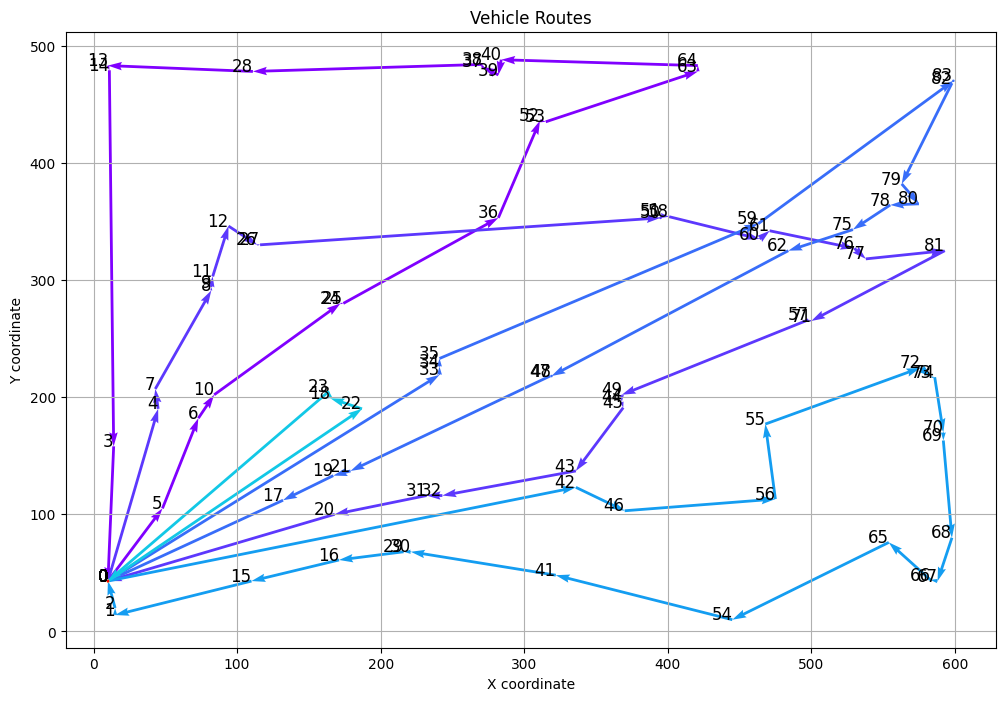

In [17]:
# 경로 시각화
plot_routes(data['locations'], routes)

In [18]:
routes

[[0, 5, 6, 10, 24, 25, 36, 52, 53, 63, 64, 40, 39, 37, 38, 28, 13, 14, 3, 0],
 [0,
  4,
  7,
  8,
  9,
  11,
  12,
  26,
  27,
  50,
  51,
  58,
  60,
  61,
  76,
  77,
  81,
  71,
  57,
  49,
  44,
  45,
  43,
  32,
  31,
  20,
  0],
 [0, 33, 34, 35, 59, 83, 82, 79, 80, 78, 75, 62, 48, 47, 21, 19, 17, 0],
 [0,
  42,
  46,
  56,
  55,
  72,
  73,
  74,
  70,
  69,
  68,
  67,
  66,
  65,
  54,
  41,
  30,
  29,
  16,
  15,
  1,
  2,
  0],
 [0, 22, 18, 23, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0]]